# Intensity Free<br>
A modification of the original intensity free script to provide simulation of new data points and culling of input data points, in line with modelling the RHS of the split distribution

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



## Preconfiguration/Setup

In [ ]:
#files
modelSaveLoc = "/ifl-tpp/model.pt" #where to save the learned model
distSaveLoc = f"/ifl-tpp/data/synth.npz" #where to save the simulated distribution
backendCodeLoc = "/ifl-tpp/code"

#tweakables
RHS_only = True #Model only the RHS of the distribution. Only works with one input file.
min_val = 0.00025 #all interarrivals less than this will be culled if RHS_only is true (this is the split location)

In [ ]:
#scripts for formatting the data to be used by this script. Expects the original data to be in 'data.csv'
#this can be changed inside package_data.py
#!cd "/ifl-tpp/"; python package_data.py 4 12.5 128
#!cd "/ifl-tpp/"; python package_data.py 1 45 128

In [ ]:
import sys
sys.path.append(backendCodeLoc)
import dpp
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as td
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
torch.set_default_tensor_type(torch.cuda.FloatTensor)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Config

Change the values bellow to train on other datasets / with other models.

In [ ]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## General data config
dataset_name = '4-raw' # the name of the dataset to use, expects it in the 'data' folder

split = 'whole_sequences' # How to split the sequences (other 'each_sequence' -- split every seq. into train/val/test)

## General model config
use_history = True        # Whether to use RNN to encode history
history_size = 64         # Size of the RNN hidden vector
rnn_type = 'LSTM'         # Which RNN cell to use (other: ['GRU', 'LSTM'])
use_embedding = False     # Whether to use sequence embedding (should use with 'each_sequence' split)
embedding_size = 64       # Size of the sequence embedding vector
                          # IMPORTANT: when using split = 'whole_sequences', the model will only learn embeddings
                          # for the training sequences, and not for validation / test
trainable_affine = False  # Train the final affine layer

## Decoder config
decoder_name = 'LogNormMix' # other: ['RMTPP', 'FullyNeuralNet', 'Exponential', 'SOSPolynomial', 'DeepSigmoidalFlow']
n_components = 32           # Number of components for a mixture model
hypernet_hidden_sizes = []  # Number of units in MLP generating parameters ([] -- affine layer, [64] -- one layer, etc.)

## Flow params
# Polynomial
max_degree = 3  # Maximum degree value for Sum-of-squares polynomial flow (SOS)
n_terms = 4     # Number of terms for SOS flow
# DSF / FullyNN
n_layers = 2    # Number of layers for Deep Sigmoidal Flow (DSF) / Fully Neural Network flow (Omi et al., 2019)
layer_size = 64 # Number of mixture components / units in a layer for DSF and FullyNN

## Training config
regularization = 1e-5 # L2 regularization parameter
learning_rate = 1e-3  # Learning rate for Adam optimizer
max_epochs = 5000     # For how many epochs to train
display_step = 50     # Display training statistics after every display_step
patience = 50         # After how many consecutive epochs without improvement of val loss to stop training

## Data

- Load dataset
- Split into training / validation / test set
- Normalize input inter-event times
- Break down long traning set sequences

In [ ]:
if '+' not in dataset_name:
    if (RHS_only):
        dataset = dpp.data.load_dataset_min(dataset_name, min_val=min_val)
    else:
        dataset = dpp.data.load_dataset(dataset_name)
else:
    # If '+' in dataset_name, load all the datasets together and concatenate them
    # For example, dataset_name='synth/poisson+synth/renewal' loads poisson and renewal datasets
    dataset_names = [d.strip() for d in dataset_name.split('+')]
    dataset = dpp.data.load_dataset(dataset_names.pop(0))
    for d in dataset_names:
        dataset += dpp.data.load_dataset(dataset_names.pop(0))

# Split into train/val/test, on each sequence or assign whole sequences to different sets
if split == 'each_sequence':
    d_train, d_val, d_test = dataset.train_val_test_split_each(seed=seed)
elif split == 'whole_sequences':
    d_train, d_val, d_test = dataset.train_val_test_split_whole(seed=seed)
else:
    raise ValueError(f'Unsupported dataset split {split}')

# Calculate mean and std of the input inter-event times and normalize only input
mean_in_train, std_in_train = d_train.get_mean_std_in()
std_out_train = 1.0
d_train.normalize(mean_in_train, std_in_train, std_out_train)
d_val.normalize(mean_in_train, std_in_train, std_out_train)
d_test.normalize(mean_in_train, std_in_train, std_out_train)

# Break down long train sequences for faster batch traning and create torch DataLoaders
d_train.break_down_long_sequences(128)
collate = dpp.data.collate
dl_train = torch.utils.data.DataLoader(d_train, batch_size=64, shuffle=True, collate_fn=collate)
dl_val = torch.utils.data.DataLoader(d_val, batch_size=1, shuffle=False, collate_fn=collate)
dl_test = torch.utils.data.DataLoader(d_test, batch_size=1, shuffle=False, collate_fn=collate)

# Set the parameters for affine normalization layer depending on the decoder (see Appendix D.3 in the paper)
if decoder_name in ['RMTPP', 'FullyNeuralNet', 'Exponential']:
    _, std_out_train = d_train.get_mean_std_out()
    mean_out_train = 0.0
else:
    mean_out_train, std_out_train = d_train.get_log_mean_std_out()

Loading data...
0.00039005299913696945


## Model setup

- Define the model config
- Define the optimizer

In [ ]:
# General model config
general_config = dpp.model.ModelConfig(
    use_history=use_history,
    history_size=history_size,
    rnn_type=rnn_type,
    use_embedding=use_embedding,
    embedding_size=embedding_size,
    num_embeddings=len(dataset),
)

# Decoder specific config
decoder = getattr(dpp.decoders, decoder_name)(general_config,
                                              n_components=n_components,
                                              hypernet_hidden_sizes=hypernet_hidden_sizes,
                                              max_degree=max_degree,
                                              n_terms=n_terms,
                                              n_layers=n_layers,
                                              layer_size=layer_size,
                                              shift_init=mean_out_train,
                                              scale_init=std_out_train,
                                              trainable_affine=trainable_affine)

# Define model
model = dpp.model.Model(general_config, decoder)
model.use_history(general_config.use_history)
model.use_embedding(general_config.use_embedding)

# Define optimizer
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

## Training

- Run for max_epochs or until the early stopping condition is satisfied
- Calculate and save the training statistics

In [ ]:
# Function that calculates the loss for the entire dataloader
def get_total_loss(loader):
    loader_log_prob, loader_lengths = [], []
    for input in loader:
        loader_log_prob.append(model.log_prob(input).detach())
        loader_lengths.append(input.length.detach())
    return -model.aggregate(loader_log_prob, loader_lengths)

In [ ]:
impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []
for epoch in range(max_epochs):
    model.train()
    for input in dl_train:
        opt.zero_grad()
        log_prob = model.log_prob(input)
        loss = -model.aggregate(log_prob, input.length)
        loss.backward()
        opt.step()

    model.eval()
    loss_val = get_total_loss(dl_val)
    training_val_losses.append(loss_val.item())

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val.item()
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val.item()
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if (epoch + 1) % display_step == 0:
        print(f"Epoch {epoch+1:4d}, loss_train_last_batch = {loss:.4f}, loss_val = {loss_val:.4f}")

Epoch   50, loss_train_last_batch = -2.1351, loss_val = -2.4847
Epoch  100, loss_train_last_batch = -3.1897, loss_val = -2.5670
Epoch  150, loss_train_last_batch = -2.7778, loss_val = -2.6492
Epoch  200, loss_train_last_batch = -2.5979, loss_val = -2.6939
Epoch  250, loss_train_last_batch = -4.4496, loss_val = -2.7043
Epoch  300, loss_train_last_batch = -3.6371, loss_val = -2.7804
Epoch  350, loss_train_last_batch = -3.4573, loss_val = -2.8355
Epoch  400, loss_train_last_batch = -2.7067, loss_val = -2.8411
Epoch  450, loss_train_last_batch = -2.3216, loss_val = -2.8692
Epoch  500, loss_train_last_batch = -2.3602, loss_val = -2.8710
Epoch  550, loss_train_last_batch = -3.0704, loss_val = -2.8668
Epoch  600, loss_train_last_batch = -3.5139, loss_val = -2.8967
Epoch  650, loss_train_last_batch = -3.5007, loss_val = -2.9034
Epoch  700, loss_train_last_batch = -3.6317, loss_val = -2.9141
Epoch  750, loss_train_last_batch = -2.8044, loss_val = -2.9124
Breaking due to early stopping at epoch 

## Evaluation

- Load the best model
- Calculate the train/val/test loss
- Plot the training curve

In [ ]:
model.load_state_dict(best_model)
model.eval()
torch.save(model.state_dict(), modelSaveLoc) #save the model

pdf_loss_train = get_total_loss(dl_train)
pdf_loss_val = get_total_loss(dl_val)
pdf_loss_test = get_total_loss(dl_test)

print(f'Time NLL\n'
      f'Train: {pdf_loss_train:.4f}\n'
      f'Val:   {pdf_loss_val.item():.4f}\n' 
      f'Test:  {pdf_loss_test.item():.4f}')

Time NLL
Train: -3.1024
Val:   -2.9388
Test:  -2.8956


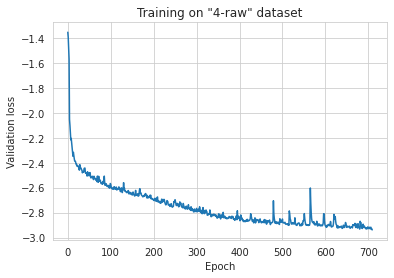

In [ ]:
training_val_losses = training_val_losses[:-patience] # plot only until early stopping
plt.plot(range(len(training_val_losses)), training_val_losses)
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.title(f'Training on "{dataset_name}" dataset')
plt.show()

# Simulation (Added)

In [ ]:
#this simulation loop is very slow, so prepare to wait if generating any significant number of new points

#load the best model
model = dpp.model.Model(general_config, decoder)
model.use_history(general_config.use_history)
model.use_embedding(general_config.use_embedding)
model.load_state_dict(torch.load(modelSaveLoc))
model.eval()

sec = 1000000000 #ns
#tweakable parameters
stop = 179000 #how many points to simmulate
upper_limit = 36 #the maximum interarrival time allowed (anything greater is culled)

#do the input loop
#get a length of data to use as the starting history input
#format it so it can understand it
#do the prediction and transformations
#feed the result back in as extra history

#data to simulate, this should be the same as what was used to train the model
f = np.load(f"/ifl-tpp/data/{dataset_name}.npz", allow_pickle=True)

#prepare data for simulation
deltas = np.ediff1d(np.concatenate(f["arrival_times"]))
deltas = deltas[deltas >= min_val]
chunkSize = 128
#resplit
deltas = np.asarray([list(np.concatenate([[1.0],deltas[x+1:x+chunkSize]])) for x in range(0, len(deltas), chunkSize)])
history_input = [deltas[-10].copy()]

new_points = []
i = 0
oh_no = 0 #problems

while (i < stop):
    #print(history_input)

    d_hist = dpp.data.SequenceDataset(delta_times=history_input, log_mode=True)
    d_hist.normalize(mean_in_train, std_in_train, std_out_train)
    dl_hist = torch.utils.data.DataLoader(d_hist, batch_size=1, shuffle=False, collate_fn=collate)

    for input in dl_hist:
        #print(input)
        predictionl = model.predict(input).detach()
        break

    #data transformation process
    #when loaded, turned into log via natural logarithm
    #before training, data is normalised
    #training is performed
    #predict new points given history (needs to be logged and normalised [using same normalisation parameters])
    #given a list of points (most likely each point is using the last n points as history)

    prediction = predictionl[0]
    #reverse the normalisation => self.in_times = [(t - mean_in) / std_in for t in self.in_times]
    #reverse the log
    #from the top => mean_in_train, std_in_train
    delta = ((prediction * std_in_train) + mean_in_train).exp().cpu().numpy().item() #the end bit removes it from the gpu

    
    #if the generated point is outside reasonable bounds (cull anything less than 1ns and > max time)
    if (delta < 0.1/sec or delta > upper_limit):
        #print(f"oh no: {delta}")
        oh_no += 1
    else:
        #add on new point
        new_points.append(delta)
        history_input[0] = np.roll(history_input[0],-1)
        history_input[0][-1] = delta
        i += 1
        if (i % 200 == 0):
            print(f"\r{' '*20}\r{100*i/stop}%", flush=True, end='')

new_points = np.array(new_points)

print(f"\Culled Points: {oh_no} ({100/stop * oh_no}%)")


100.0%
oh no: 12485 (6.9748603351955305%)


In [ ]:
#Save the generated points
np.savez(modelSaveLoc, deltas=new_points)